In [ ]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/data/bigmamma

Mounted at /content/drive
/content/drive/MyDrive/data/bigmamma


# Pipline architecture
From the project requirements, the search is done by plot and filters. The following diagram highlights the pipline structure and how it works in general.

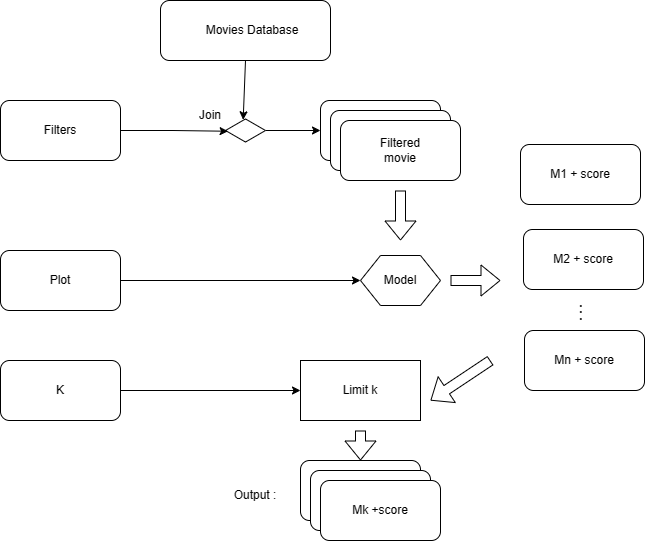

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: wiki_movie_plots_deduped.csv  


In [ ]:
#imports
import pandas as pd
import numpy as np
#settings
pd.set_option('display.max_colwidth', -1) #to display full plot

<ipython-input-2-b2db77c6d5be>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1) #to display full plot


# Data Handchake:
Reading and visualizing our data structure:

In [ ]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')
df_copy = df.copy()
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Smashers,"A bartender is working at a saloon, serving drinks to customers. After he fills a stereotypically Irish man's bucket with beer, Carrie Nation and her followers burst inside. They assault the Irish man, pulling his hat over his eyes and then dumping the beer over his head. The group then begin wrecking the bar, smashing the fixtures, mirrors, and breaking the cash register. The bartender then sprays seltzer water in Nation's face before a group of policemen appear and order everybody to leave.[1]"
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Light_of_the_Moon,"The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon's smile gets bigger. They then sit down on a bench by a tree. The moon's view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see everything better."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Presidents,"The film, just over a minute long, is composed of two shots. In the first, a girl sits at the base of an altar or tomb, her face hidden from the camera. At the center of the altar, a viewing portal displays the portraits of three U.S. Presidents—Abraham Lincoln, James A. Garfield, and William McKinley—each victims of assassination.\r\nIn the second shot, which runs just over eight seconds long, an assassin kneels feet of Lady Justice."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_the_Grizzly_King","Lasting just 61 seconds and consisting of two shots, the first shot is set in a wood during winter. The actor representing then vice-president Theodore Roosevelt enthusiastically hurries down a hillside towards a tree in the foreground. He falls once, but rights himself and cocks his rifle. Two other men, bearing signs reading ""His Photographer"" and ""His Press Agent"" respectively, follow him into the shot; the photographer sets up his camera. ""Teddy"" aims his rifle upward at the tree and fells what appears to be a common house cat, which he then proceeds to stab. ""Teddy"" holds his prize aloft, and the press agent takes notes. The second shot is taken in a slightly different part of the wood, on a path. ""Teddy"" rides the path on his horse towards the camera and out to the left of the shot, followed closely by the press agent and photographer, still dutifully holding their signs."
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Beanstalk_(1902_film),"The earliest known adaptation of the classic fairytale, this films shows Jack trading his cow for the beans, his mother forcing him to drop them in the front yard, and beig forced upstairs. As he sleeps, Jack is visited by a fairy who shows him glimpses of what will await him when he ascends the bean stalk. In this version, Jack is the son of a deposed king. When Jack wakes up, he finds the beanstalk has grown and he climbs to the top where he enters the giant's home. The giant finds Jack, who narrowly escapes. The giant chases Jack down the bean stalk, but Jack is able to cut it down before the giant can get to safety. He falls and is killed as Jack celebrates. The fairy then reveals that Jack may return home as a prince."


In [ ]:
df.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


In [ ]:
df.shape

(34886, 8)

In [ ]:
df.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot'],
      dtype='object')

In [ ]:
# making the filtering function
def filter_movies(k, plot, filters, df):
  #selecting relevant fields
  result = df[['Release Year', 'Title', 'Genre', 'Plot']].copy()
  #year based selection
  if 'start_release_year' in filters:
    result = result[result['Release Year'] >= filters['start_release_year']]
  if 'end_release_year' in filters:
    result = result[result['Release Year'] <= filters['end_release_year']]
  #Genre based selection
  if 'genre' in filters:
    result = result[result['Genre'] == filters['genre']]
  return result

#testing
result = filter_movies(10, 'Non sense Plot', {'start_release_year': 1980, 'end_release_year': 1990, 'genre': 'comedy'}, df)
result

,Release Year,Title,Genre,Plot
9681,1980,Die Laughing,comedy,A young cab driver and aspiring singer becomes...
9691,1980,The Fiendish Plot of Dr. Fu Manchu,comedy,"The opening titles announce it is set ""possibl..."
9694,1980,First Family,comedy,Manfred Link is the President of the United St...
9703,1980,The Gong Show Movie,comedy,The film shows a fictional week in the life of...
9706,1980,Health,comedy,Bearing similarities to Altman's 1975 film Nas...
...,...,...,...,...
25487,1988,Maalamaal,comedy,"Raj, a small-time cricketer, discovers that hi..."
25547,1990,Appu Raja,comedy,Sethupathi (Kamal Haasan) is an honest and upr...
33094,1980,Tora's Tropical Fever,comedy,"Lily, the lounge singer with whom Tora-san fel..."
33122,1984,Tora-san's Forbidden Love,comedy,In the midst of Japan's rising economy of the ...


# 1) Model Building
Building a model that: given 2 movie plots, returns the similarity score between the 2 movies.
In general, when working on an NLP problem, the main challenge is to find the best vector representaion of the sentences which we call "Sentence Embeddings". Good sentence embeddings improves the ability of the model to capture the underlying patterns that exists in language. For this reason we offten use pretrained models like BERT to handle the embedding part, and adapt (FineTune) the models on our specific tasks. For the Sentence Similarity Tasks, an improved approach was introduced in the paper: [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf). The paper introduced a set of models that provides a better way of performing sts by reducing the inference time. For that we will be using pretrained Sentence-Bert models from HugginFace to find the similarity score between the plot (search token) and the movies plots in our Movies DataBase (the corpus).

In [ ]:
%pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=48dc23a2503ae1d0f0da02a6d50c3c3971ee6c2e11418c152bc68532ebe12a00
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
#imports
from sentence_transformers import SentenceTransformer, util

# Model 1: **msmarco-bert-base-dot-v5**
Model card: https://huggingface.co/sentence-transformers/msmarco-bert-base-dot-v5


In [ ]:
#Plot: 'A young cab driver and aspiring singer becomes embroiled in a plot to kidnap a monkey that has memorized a scientific formula with the potential to destroy the world.'
plot = "A cab driver who kidnaps a monkey"
search_space = filter_movies(10, plot, {'start_release_year': 1980, 'end_release_year': 1982, 'genre': 'comedy'}, df).head(10)

In [ ]:
#importing the model
model = SentenceTransformer('msmarco-bert-base-dot-v5')

In [ ]:
#generating embeddings
plot_embedding = model.encode(plot, convert_to_tensor=True)
search_space_embeddings = model.encode(search_space['Plot'].values, convert_to_tensor=True)

In [ ]:
#calculating dot_score
result = util.dot_score(plot_embedding, search_space_embeddings)
search_space['Score'] = result[0].cpu()

#Score based sorting
search_space.sort_values('Score', ascending=False).head()

,Release Year,Title,Genre,Plot,Score
9681,1980,Die Laughing,comedy,A young cab driver and aspiring singer becomes embroiled in a plot to kidnap a monkey that has memorized a scientific formula with the potential to destroy the world.,179.576218
9711,1980,The Hollywood Knights,comedy,"On Halloween night in 1965, a group of high school pranksters – the Hollywood Knights – are enraged by the Beverly Hills Residents' Association's success in arranging for the shutdown and demolition of their favorite hangout, 'Tubby's Drive-In' diner, which is to be replaced by an office building. In response, they launch a sustained and comically vengeful campaign against the principals of the association and two bumbling local police officers charged with keeping ""The Knights"" in check during their last night in Beverly Hills. The ensuing antics include, among other things, a sexual encounter involving premature ejaculation, a punch bowl being 'spiked' with urine, an initiation ceremony involving four pledges who are left in Watts wearing nothing but the car tires they are left to carry, a cheerleader who forgets to put on her underwear before performing at a pep rally, several impromptu drag races, and the lead character of Newbomb Turk (Robert Wuhl) wearing a majordomo outfit and singing a version of 'Volare' accompanied by the sounds of flatulence. 'Mooning' also plays a prominent role in the film: one of the advertising slogans exploited the recent Apollo space program by touting that The Hollywood Knights was the first movie 'to moon a man on the land'. During a mooning incident in the film's final scene, the character Dudley Laywicker, becomes absolutely 'all eyes', transfixed by the bare buttocks. So much so, that he takes his glasses off for a better look.",163.682205
9717,1980,In God We Tru$t,comedy,"A naive monk, Brother Ambrose (Feldman), is sent by the abbot on a mission to raise $5000 in order to save their monastery from closing. He goes to Hollywood where he encounters a number of eccentric characters. He is at first robbed and later befriended by con artist Dr. Sebastian Melmoth (Boyle), and meets a prostitute named Mary (Lasser) who lets him stay at her apartment. Mary grows to care for Ambrose and seduces him while he is taking a cold shower to try to alleviate his lustful thoughts about her. While he is in Hollywood, he visits several churches including a service at the Church of Divine Profit, performed by the televangelist Armageddon T. Thunderbird (Kaufman) in which he sees the focus of the sermon being a request for money in exchange for salvation. Ambrose is angered by this message and tries to meet a number of times with Thunderbird, being ejected each time.\r\nDr. Melmoth and Ambrose travel the city in a modified school bus, in which they hold church services for donations. During one service, the brakes of the bus release and the bus rolls downhill into a river. The passengers escape safely in the river and are shown on the local news being baptized by the pair, which catches Thunderbird's attention. He prays to G. O. D. for guidance and it tells him to work with Ambrose to make more money because Ambrose is an innocent and has a clean image.\r\nThunderbird has his minions kidnap Ambrose and bring him to his office where he outlines a plan for his own brand of church on wheels. He says he will pay Ambrose the $5000 the monastery needs if he assists him. While they are talking, Thunderbird mentions that G. O. D. (Richard Pryor) audibly talks to him when he prays to him and Ambrose is surprised because he himself has never heard from God in this way. Ambrose agrees to work with Thunderbird and they go across the country from town to town holding services in their own bus.\r\nOne day at Thunderbird's headquarters, Ambrose overhears Thunderbird praying to G. O. D. in his private chamber and when he hears G. O. D. speak back to him, he is intrigued. When Thunderbird leaves, he sneaks into the chamber and discovers that G.

# Note:
Our model works fine so far, we will build a pipline using it, make an mvp and then try other mothods.

# **Model 2:** Going a step further with Domain Adaptation using Generative Pseudo-Labeling
In the second model, after making a proof of concept model, integrating the model in our project and validating all designed unittest. We will use the gpl from the sbert documentation to adapt our movies semantic search model

### Step 1: Cloning the repo

In [ ]:
!git clone https://github.com/UKPLab/gpl.git

Cloning into 'gpl'...
remote: Enumerating objects: 317, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 317 (delta 62), reused 80 (delta 38), pack-reused 189
Receiving objects: 100% (317/317), 418.65 KiB | 2.26 MiB/s, done.
Resolving deltas: 100% (142/142), done.


### Step 2: Creating the dataset out of our Corpus
Following the documentation, we need to reformat our corpus in a specific format inorder to be processed by the gpl.

In [ ]:
import json
data = pd.read_csv('wiki_movie_plots_deduped.csv')


In [ ]:
id=0
with open('corpus.jsonl', 'w') as outfile:
    for movie in data['Plot'].values:
        json.dump({'text': movie, 'title': '', '_id': str(id)}, outfile)
        id+=1
        outfile.write('\n')

In [ ]:
!cp corpus.jsonl ./gpl/generated/corpus.jsonl

In [ ]:
%cd gpl/

/content/drive/MyDrive/data/bigmamma/gpl


In [ ]:
!pip install -e .
#gpl dependency
!pip install -q -U "tensorflow-text==2.11.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/data/bigmamma/gpl
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.8/393.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!python -m gpl.train \
    --path_to_generated_data "generated" \
    --output_dir "output" \
    --new_size -1 \
    --queries_per_passage -1

2023-06-17 17:17:56.888137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-17 17:17:56.888391: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-17 17:17:56.888425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-06-17 17:18:02 - Loading faiss with AVX2 support.
2023-06-17 17:18:02 - Successfully loaded faiss with AVX

Unfortunately are model did not complete it's training since the time is short I decided to stick to the first model and integrate it with my project.

# **Conclusion**
This project was really a good learning opportunity. In this specific problem, the computation time is important and sentence-BERT works relatively fine comparing to using BERT directly on my local machine. We can go further in this project by trying diffrent models from the sentence-BERT library or figuring out a way to perform gpl on our movies corpus. The model deployed in the platform is s-bert msmarco-bert-base-dot-v5.